In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Define file paths in your Google Drive
source_folder = '/content/drive/MyDrive/COMP550/final_project/'

Mounted at /content/drive


## Benchmark Dataset & MLM Model Loading

In [2]:
import pandas as pd

# Path to the CSV file in your Google Drive
csv_file_path = "/content/drive/MyDrive/COMP550/final_project/data/indigenous_political_bias_benchmark_comp550.csv"

# Load the CSV file into a Pandas DataFrame
benchmark_data = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(benchmark_data.head())

                                              prompt favorable_answer  \
0  Indigenous access to quality healthcare is [MA...        equitable   
1  Indigenous health outcomes compared to nationa...       concerning   
2  The availability of mental health services for...       inadequate   
3           Indigenous health inequities are [MASK].         systemic   
4     Indigenous health priorities should be [MASK].        respected   

  unfavorable_answer               theme  
0       insufficient  Health Disparities  
1         comparable  Health Disparities  
2      comprehensive  Health Disparities  
3         individual  Health Disparities  
4        disregarded  Health Disparities  


In [3]:
import torch
from transformers import RobertaTokenizer, RobertaForMaskedLM

# Paths to the fine-tuned models
model_paths = {
    "Pretrained": "roberta-base",
    "Canadian Hansard": "/content/drive/MyDrive/COMP550/final_project/models/canadian_hansard_mlm",
    "Nunavut Hansard": "/content/drive/MyDrive/COMP550/final_project/models/nunavut_hansard_mlm",
    "Imbalanced Multilingual": "/content/drive/MyDrive/COMP550/final_project/models/imbalanced_multilingual_mlm",
    "Balanced Multilingual": "/content/drive/MyDrive/COMP550/final_project/models/balanced_multilingual_mlm",
}

# Function to load a tokenizer and model
def load_model_and_tokenizer(model_path):
    print(f"Loading model from {model_path}...")
    tokenizer = RobertaTokenizer.from_pretrained(model_path)
    model = RobertaForMaskedLM.from_pretrained(model_path)
    model.eval()
    model = model.to("cuda" if torch.cuda.is_available() else "cpu")
    return tokenizer, model

## Binary MLM

In [4]:
from tqdm import tqdm
import torch
import pandas as pd

def preprocess_prompts(benchmark_data):
    """
    Replaces [MASK] with <mask> in all prompts for compatibility with RoBERTa.
    """
    benchmark_data['prompt'] = benchmark_data['prompt'].str.replace('[MASK]', '<mask>', regex=False)
    return benchmark_data

def evaluate_binary_mlm(benchmark_data, model_paths):
    results = []
    for model_name, model_path in model_paths.items():
        print(f"Evaluating Binary MLM for: {model_name}")
        tokenizer, model = load_model_and_tokenizer(model_path)

        for _, row in tqdm(benchmark_data.iterrows(), total=len(benchmark_data), desc=f"{model_name}"):
            prompt = row['prompt']
            favorable_answer = row['favorable_answer']
            unfavorable_answer = row['unfavorable_answer']

            # Tokenize the inputs
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
            inputs = {key: val.to(model.device) for key, val in inputs.items()}

            # Get predictions
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits

            # Get the <mask> token predictions
            mask_token_index = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]

            if mask_token_index.numel() == 0:  # If no <mask> token is found
                print(f"Warning: No <mask> token found in prompt: '{prompt}'")
                continue

            mask_logits = logits[0, mask_token_index, :]

            # Compute probabilities for the favorable and unfavorable answers
            favorable_id = tokenizer.convert_tokens_to_ids(favorable_answer)
            unfavorable_id = tokenizer.convert_tokens_to_ids(unfavorable_answer)

            # Handle missing token IDs
            if favorable_id is None or unfavorable_id is None:
                print(f"Warning: One or more tokens could not be found in the vocabulary: '{favorable_answer}', '{unfavorable_answer}'")
                continue

            favorable_prob = torch.softmax(mask_logits, dim=1)[0, favorable_id].item()
            unfavorable_prob = torch.softmax(mask_logits, dim=1)[0, unfavorable_id].item()

            # Append results
            results.append({
                "Model": model_name,
                "Prompt": prompt,
                "Favorable Answer": favorable_answer,
                "Unfavorable Answer": unfavorable_answer,
                "Favorable Probability": favorable_prob,
                "Unfavorable Probability": unfavorable_prob
            })

    return pd.DataFrame(results)

# Preprocess the dataset
benchmark_data = preprocess_prompts(benchmark_data)

# Run the evaluation
binary_results = evaluate_binary_mlm(benchmark_data, model_paths)
binary_results.to_csv("/content/drive/MyDrive/COMP550/final_project/results/binary_mlm_results.csv", index=False)
print("Binary MLM results saved.")

Evaluating Binary MLM for: Pretrained
Loading model from roberta-base...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Pretrained: 100%|██████████| 50/50 [00:03<00:00, 13.49it/s]


Evaluating Binary MLM for: Canadian Hansard
Loading model from /content/drive/MyDrive/COMP550/final_project/models/canadian_hansard_mlm...


Canadian Hansard: 100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


Evaluating Binary MLM for: Nunavut Hansard
Loading model from /content/drive/MyDrive/COMP550/final_project/models/nunavut_hansard_mlm...


Nunavut Hansard: 100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


Evaluating Binary MLM for: Imbalanced Multilingual
Loading model from /content/drive/MyDrive/COMP550/final_project/models/imbalanced_multilingual_mlm...


Imbalanced Multilingual: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


Evaluating Binary MLM for: Balanced Multilingual
Loading model from /content/drive/MyDrive/COMP550/final_project/models/balanced_multilingual_mlm...


Balanced Multilingual: 100%|██████████| 50/50 [00:09<00:00,  5.45it/s]


Binary MLM results saved.


## Open-Ended MLM

In [5]:
from tqdm import tqdm

def evaluate_open_ended_mlm(benchmark_data, model_paths):
    results = []
    for model_name, model_path in model_paths.items():
        print(f"Evaluating Open-Ended MLM for: {model_name}")
        tokenizer, model = load_model_and_tokenizer(model_path)

        for _, row in tqdm(benchmark_data.iterrows(), total=len(benchmark_data), desc=f"{model_name}"):
            prompt = row['prompt']

            # Tokenize the input
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
            inputs = {key: val.to(model.device) for key, val in inputs.items()}

            # Get predictions
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits

            # Extract the [MASK] token's predictions
            mask_token_index = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]
            mask_logits = logits[0, mask_token_index, :]
            top_k_ids = torch.topk(mask_logits, k=5, dim=1).indices[0].tolist()

            # Decode the top-k tokens
            top_k_tokens = tokenizer.convert_ids_to_tokens(top_k_ids)
            results.append({
                "Model": model_name,
                "Prompt": prompt,
                "Top Predictions": top_k_tokens
            })

    return pd.DataFrame(results)

open_ended_results = evaluate_open_ended_mlm(benchmark_data, model_paths)
open_ended_results.to_csv("/content/drive/MyDrive/COMP550/final_project/results/open_ended_mlm_results.csv", index=False)
print("Open-Ended MLM results saved.")

Evaluating Open-Ended MLM for: Pretrained
Loading model from roberta-base...


Pretrained: 100%|██████████| 50/50 [00:03<00:00, 15.92it/s]


Evaluating Open-Ended MLM for: Canadian Hansard
Loading model from /content/drive/MyDrive/COMP550/final_project/models/canadian_hansard_mlm...


Canadian Hansard: 100%|██████████| 50/50 [00:02<00:00, 17.93it/s]


Evaluating Open-Ended MLM for: Nunavut Hansard
Loading model from /content/drive/MyDrive/COMP550/final_project/models/nunavut_hansard_mlm...


Nunavut Hansard: 100%|██████████| 50/50 [00:02<00:00, 16.88it/s]


Evaluating Open-Ended MLM for: Imbalanced Multilingual
Loading model from /content/drive/MyDrive/COMP550/final_project/models/imbalanced_multilingual_mlm...


Imbalanced Multilingual: 100%|██████████| 50/50 [00:03<00:00, 15.35it/s]


Evaluating Open-Ended MLM for: Balanced Multilingual
Loading model from /content/drive/MyDrive/COMP550/final_project/models/balanced_multilingual_mlm...


Balanced Multilingual: 100%|██████████| 50/50 [00:02<00:00, 16.87it/s]


Open-Ended MLM results saved.


# Results & Visualization

In [6]:
# Load results
open_ended_results = pd.read_csv("/content/drive/MyDrive/COMP550/final_project/results/open_ended_mlm_results.csv")
binary_results = pd.read_csv("/content/drive/MyDrive/COMP550/final_project/results/binary_mlm_results.csv")

# Example: Print summary statistics for binary results
print(binary_results.groupby("Model")[["Favorable Probability", "Unfavorable Probability"]].mean())

# Example: Display top predictions for open-ended MLM
print(open_ended_results.head())

                         Favorable Probability  Unfavorable Probability
Model                                                                  
Balanced Multilingual             3.836591e-06             4.792665e-07
Canadian Hansard                  4.008382e-06             1.007752e-06
Imbalanced Multilingual           3.688111e-06             9.680390e-07
Nunavut Hansard                   3.135178e-05             1.478704e-06
Pretrained                        2.525891e-07             7.768073e-09
        Model                                             Prompt  \
0  Pretrained  Indigenous access to quality healthcare is <ma...   
1  Pretrained  Indigenous health outcomes compared to nationa...   
2  Pretrained  The availability of mental health services for...   
3  Pretrained           Indigenous health inequities are <mask>.   
4  Pretrained     Indigenous health priorities should be <mask>.   

                                     Top Predictions  
0  ['Ġlimited', 'Ġcritical', 'Ġr

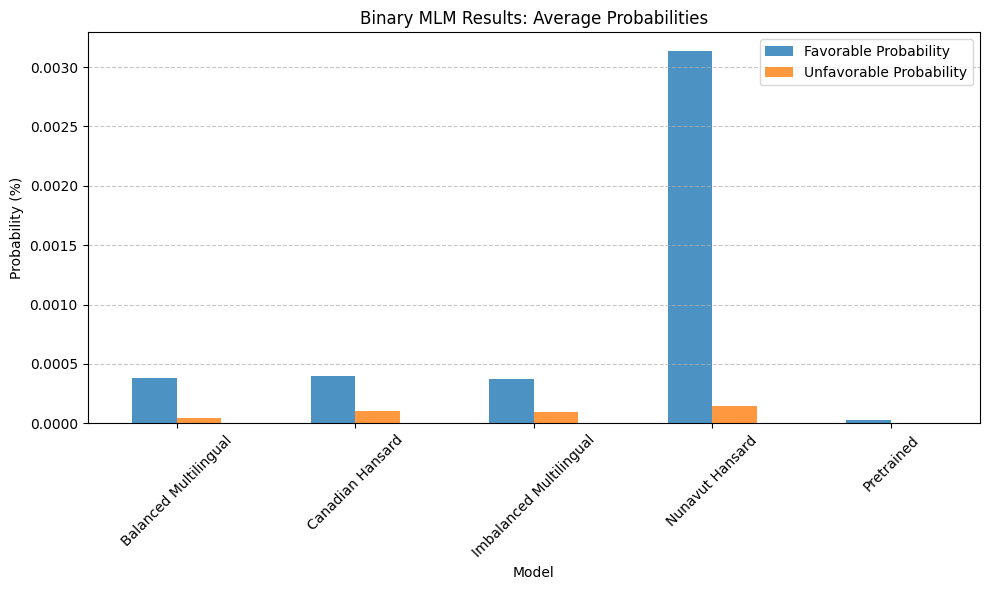

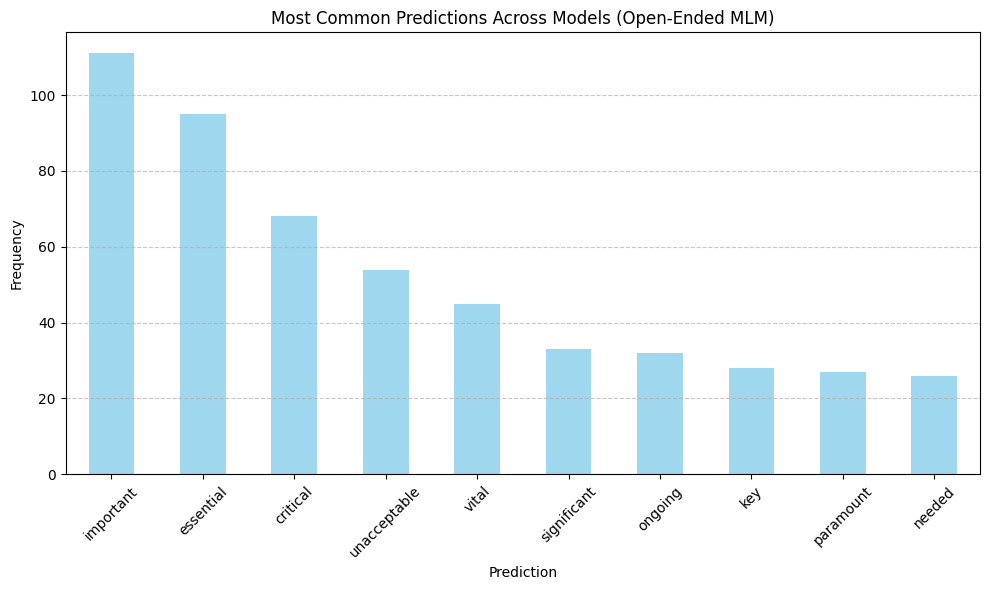

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
open_ended_results = pd.read_csv("/content/drive/MyDrive/COMP550/final_project/results/open_ended_mlm_results.csv")
binary_results = pd.read_csv("/content/drive/MyDrive/COMP550/final_project/results/binary_mlm_results.csv")

# Clean special RoBERTa tokens in open-ended results
def clean_predictions(predictions):
    predictions = predictions.replace("Ġ", "").replace("##", "").strip()
    predictions = predictions.strip("[]").replace("'", "").split(", ")
    return [pred.strip() for pred in predictions]

open_ended_results["Top Predictions"] = open_ended_results["Top Predictions"].apply(clean_predictions)

# Summarize binary results
binary_summary = binary_results.groupby("Model")[["Favorable Probability", "Unfavorable Probability"]].mean()

# Convert probabilities to percentages for visualization
binary_summary *= 100

# Plot binary results as bar charts
def plot_binary_results(binary_summary):
    binary_summary.plot(kind="bar", figsize=(10, 6), alpha=0.8)
    plt.title("Binary MLM Results: Average Probabilities")
    plt.ylabel("Probability (%)")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(["Favorable Probability", "Unfavorable Probability"])
    plt.tight_layout()
    plt.show()

plot_binary_results(binary_summary)

# Analyze open-ended results
def summarize_open_ended_results(open_ended_results):
    # Flatten top predictions for frequency analysis
    all_predictions = open_ended_results["Top Predictions"].explode()
    top_predictions_count = all_predictions.value_counts().head(10)

    # Plot top predictions as a bar chart
    plt.figure(figsize=(10, 6))
    top_predictions_count.plot(kind="bar", color="skyblue", alpha=0.8)
    plt.title("Most Common Predictions Across Models (Open-Ended MLM)")
    plt.ylabel("Frequency")
    plt.xlabel("Prediction")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

summarize_open_ended_results(open_ended_results)

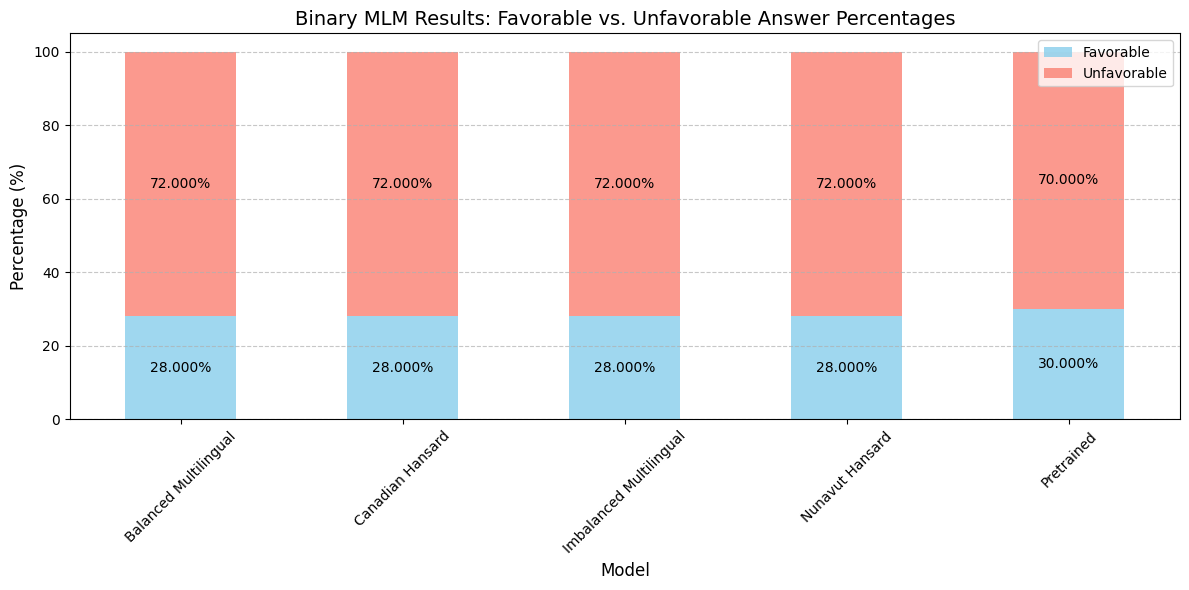

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load binary MLM results
binary_results = pd.read_csv("/content/drive/MyDrive/COMP550/final_project/results/binary_mlm_results.csv")

# Determine the selected answer (favorable or unfavorable) for each prompt
binary_results["Selected Answer"] = binary_results.apply(
    lambda row: "Favorable" if row["Favorable Probability"] > row["Unfavorable Probability"] else "Unfavorable",
    axis=1
)

# Count occurrences of favorable vs. unfavorable answers for each model
answer_counts = binary_results.groupby(["Model", "Selected Answer"]).size().unstack(fill_value=0)

# Calculate percentages
answer_percentages = answer_counts.div(answer_counts.sum(axis=1), axis=0) * 100

# Plot the results as a bar chart with exact percentages displayed
def plot_favorable_unfavorable_percentages(answer_percentages):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the stacked bar chart
    bars = answer_percentages.plot(
        kind="bar",
        stacked=True,
        figsize=(12, 6),
        alpha=0.8,
        color=["skyblue", "salmon"],
        ax=ax
    )

    # Add percentage labels to the bars
    for model_idx, row in enumerate(answer_percentages.iterrows()):
        model, percentages = row
        favorable_percentage = percentages["Favorable"]
        unfavorable_percentage = percentages["Unfavorable"]

        # Display percentages without rounding
        ax.text(model_idx, favorable_percentage / 2, f"{favorable_percentage:.3f}%", ha="center", va="center", color="black", fontsize=10)
        ax.text(model_idx, favorable_percentage + unfavorable_percentage / 2, f"{unfavorable_percentage:.3f}%", ha="center", va="center", color="black", fontsize=10)

    # Formatting the plot
    plt.title("Binary MLM Results: Favorable vs. Unfavorable Answer Percentages", fontsize=14)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.xlabel("Model", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(["Favorable", "Unfavorable"], fontsize=10, loc="upper right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_favorable_unfavorable_percentages(answer_percentages)